## Sampling versus optimization

In this problem, we consider using Langevin dynamics as sampling algorithm versus directly gradient descent to optimize a non-convex function $f(x)$, namely a function whose corresponding *density function* i.e. $e^{-f(x)}$ is a mixture gaussian.


In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from matplotlib import cm
from jax.scipy.stats.multivariate_normal import pdf as jax_normal_pdf

## Define target function

Minimum value: 0.08433961123228073
Minimum value obtained at: x=3.00, y=4.00


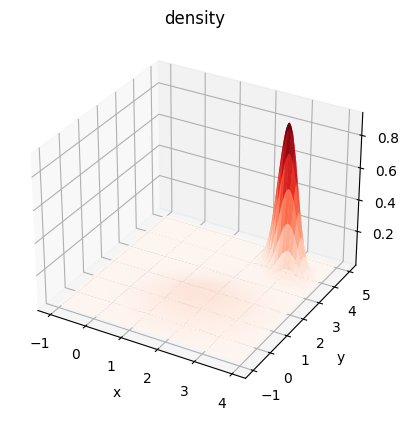

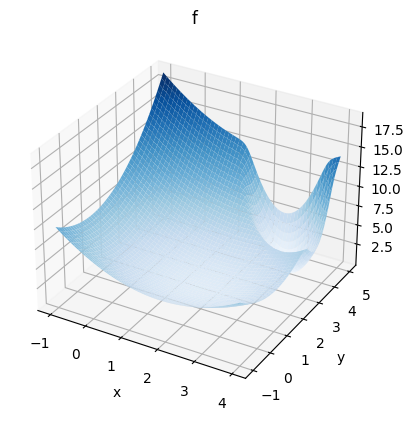

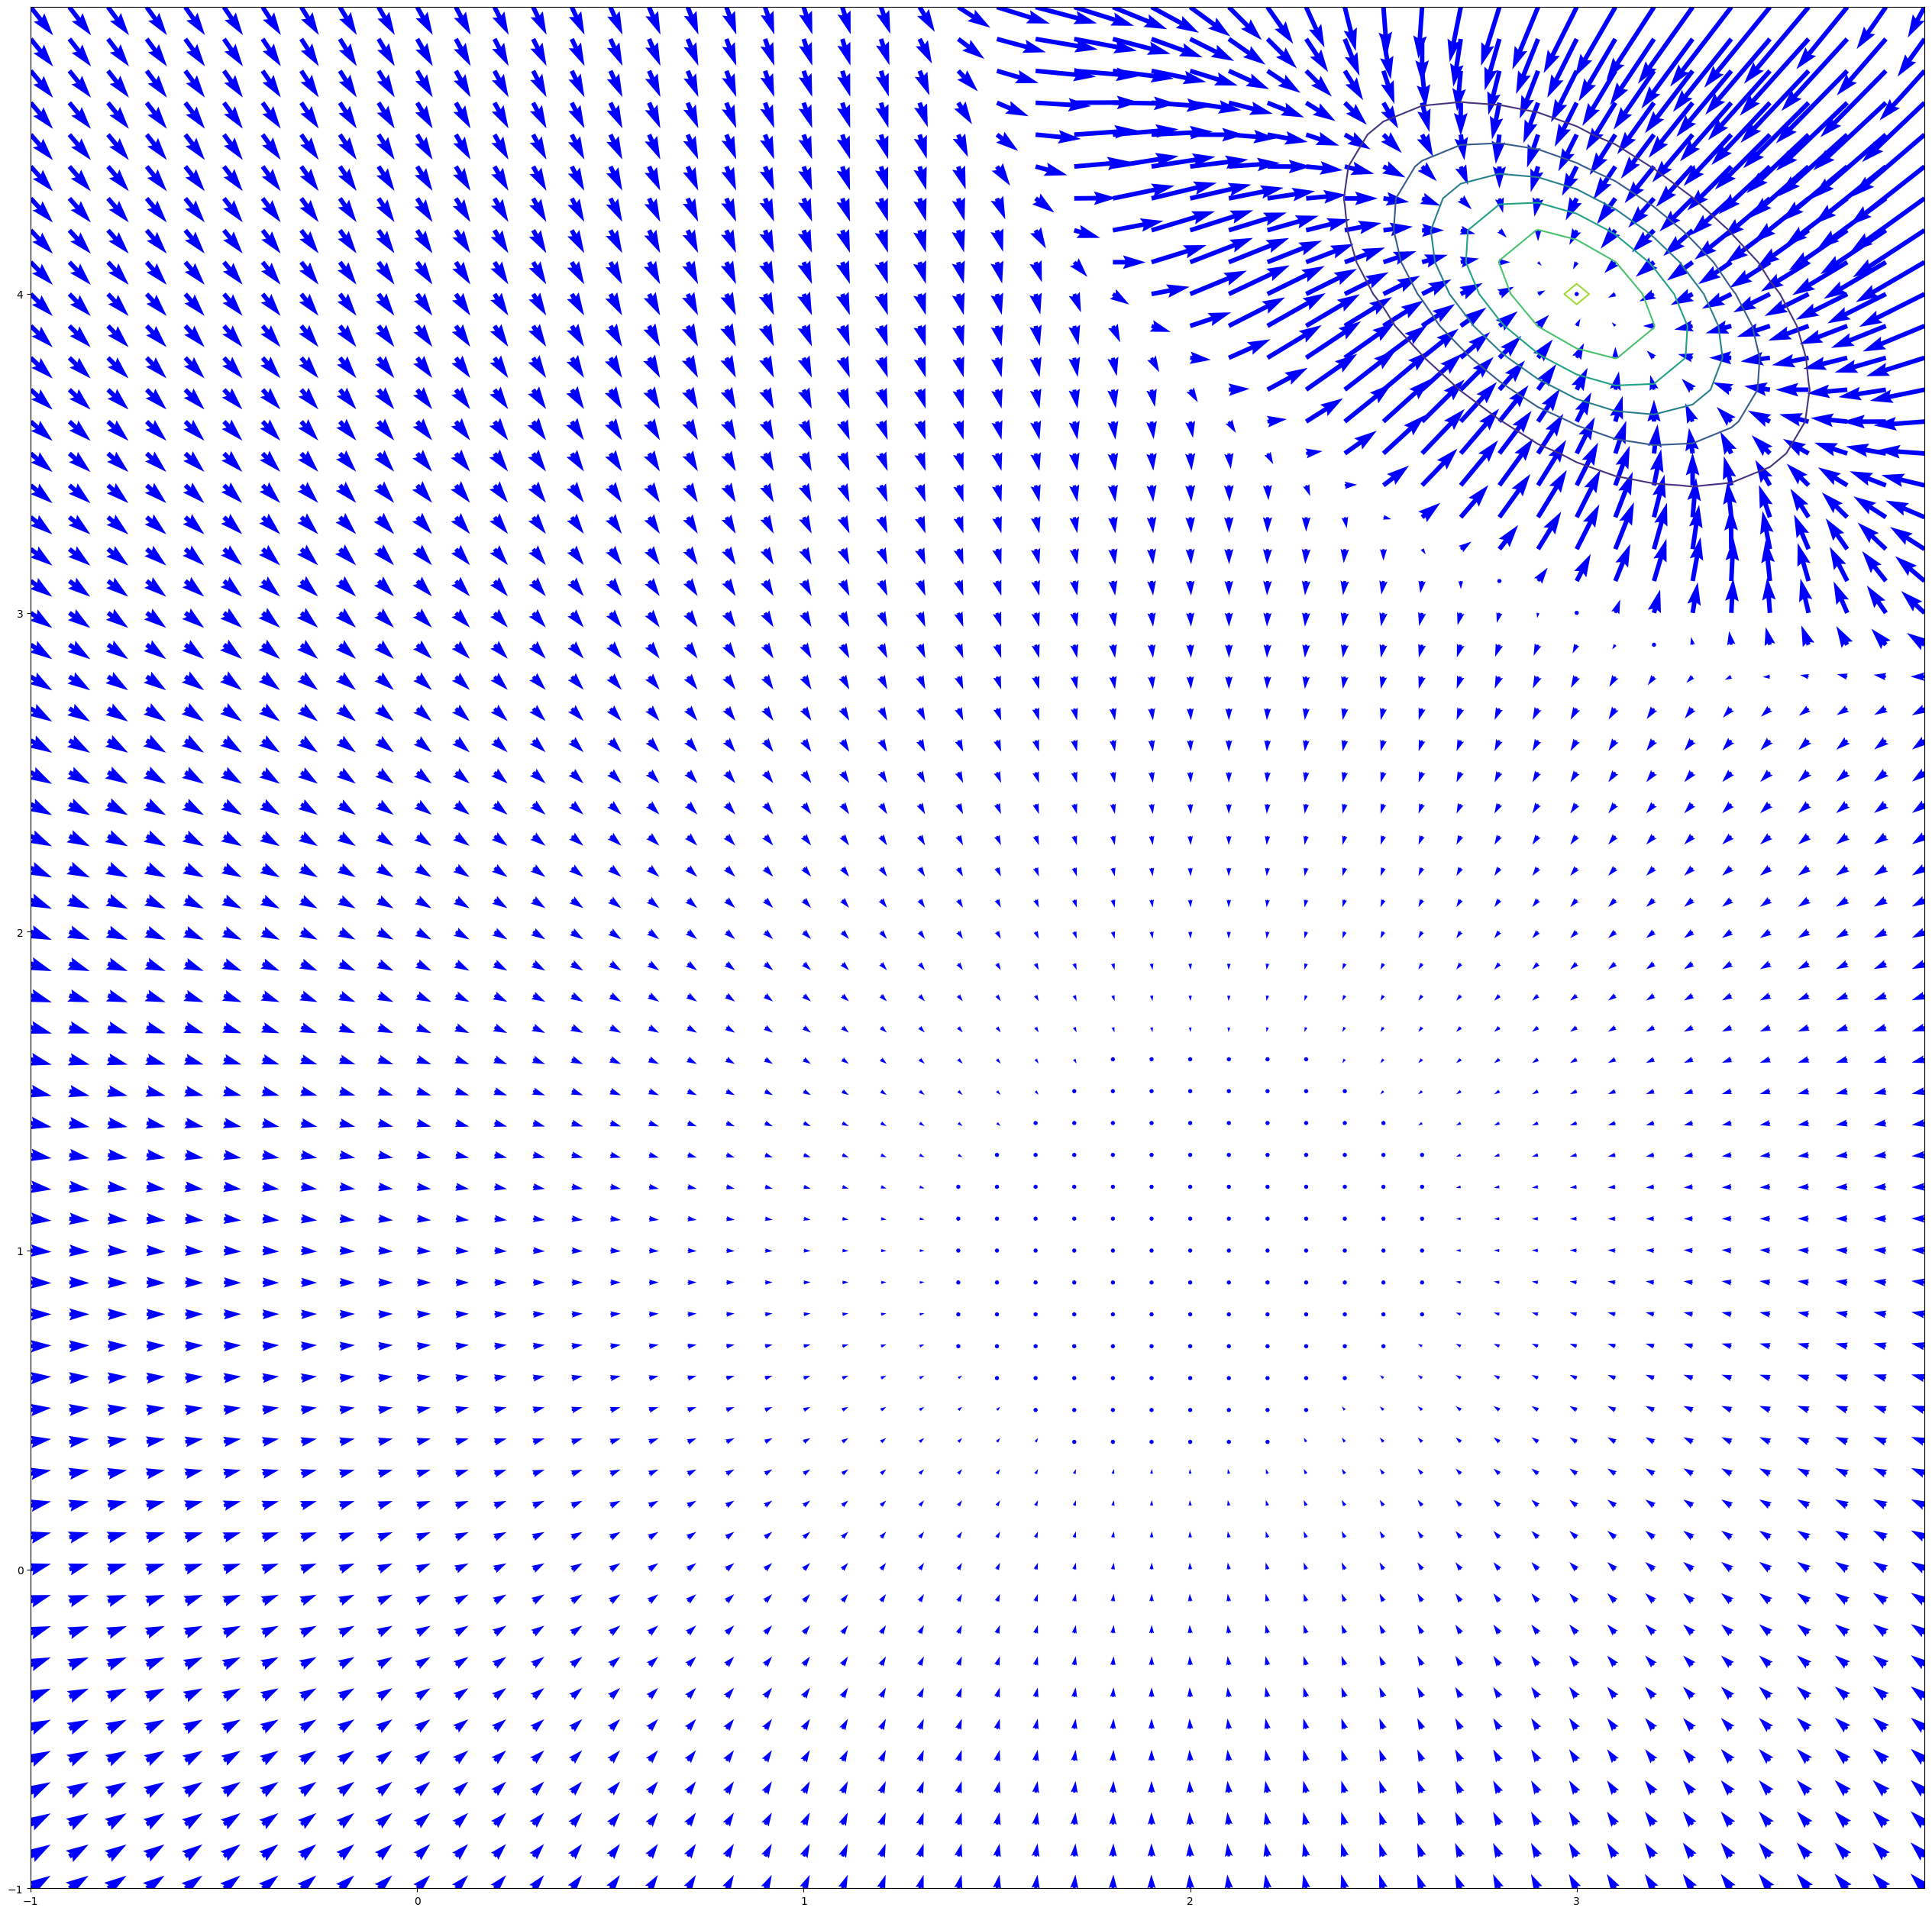

In [2]:
# Define parameters for the mixture of 2D Gaussians
means = np.array([[2, 1], [3, 4]])  # Means of the Gaussians
covs = np.array([[[0.8, 0.05], [0.05, 0.8]], [[0.1, -0.05], [-0.05, 0.1]]])  # Covariance matrices of the Gaussians
weights = [0.5, 0.5]  # Weights of the Gaussians (sums to 1)
# Define target distribution
def target_pdf(x):
    return jnp.sum(jnp.array([jax_normal_pdf(x, mean=mean, cov=cov) * weight for (mean, cov, weight) in zip(means, covs, weights)]))

def f(x):
    return -jnp.log(target_pdf(x))

def get_target_in_grid(func_fn, x_lim, y_lim):
    X, Y = np.meshgrid(np.arange(x_lim[0], x_lim[1], 0.01), np.arange(y_lim[0], y_lim[1], 0.01))
    fs = jax.vmap(func_fn)(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)
    return fs, X, Y

# visualize density and target and the score
densities, X, Y = get_target_in_grid(target_pdf, [-1, 4], [-1, 5])


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, densities, cmap=cm.Reds)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("density")

fs, X, Y = get_target_in_grid(f, [-1, 4], [-1, 5])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, fs, cmap=cm.Blues)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("f")

argmin_index = np.unravel_index(np.argmin(fs, axis=None), fs.shape)
argmin_f = np.array([X[argmin_index], Y[argmin_index]])
min_f = np.min(fs)

print(f"Minimum value: {min_f}")
print(f"Minimum value obtained at: x={argmin_f[0]:.2f}, y={argmin_f[1]:.2f}")

fig = plt.figure(figsize=(32, 32))
ax = fig.add_subplot()
X, Y = np.meshgrid(np.arange(-1, 4, 0.1), np.arange(-1, 5, 0.1))
# Construct score plot
scores = -jax.vmap(jax.grad(f))(np.stack([X.ravel(), Y.ravel()], axis=1))
dX = scores[:,0].reshape(X.shape)
dY = scores[:,1].reshape(Y.shape)
ax.quiver(X, Y, dX, dY, color='b')
pdfs = jax.vmap(target_pdf)(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)
# Construct density plot
ax.contour(X, Y, pdfs)

plt.show()


## Result details

For both methods, we start our initial variables from a standard gaussian. We then run fixed time step of update. We repeat this for many times, and select the one with lowest target variable as the final output 

In [3]:
step_size = 0.01
total_step = 5000
sample_size = 100

grad_f = jax.jit(jax.grad(f))

def gradient_descent_step(x):
    return x - step_size * grad_f(x)

def gradient_denscent(xs):
    for i in range(total_step):
        xs = jax.vmap(gradient_descent_step)(xs)
    return xs

def ULA_step(x, random_key):
    z = jax.random.multivariate_normal(random_key, jnp.zeros_like(x), jnp.diag(jnp.ones_like(x)))
    return x - step_size * grad_f(x) + (2 * step_size) **0.5 * z

def ULA(xs):
    random_key = jax.random.PRNGKey(0)
    for i in range(total_step):
        random_key, key_to_use = jax.random.split(random_key)
        key_to_uses = jax.random.split(key_to_use, sample_size)
        xs = jax.vmap(ULA_step)(xs, key_to_uses)
    return xs

x0s = np.random.multivariate_normal(np.zeros(2), np.eye(2), size=sample_size)

xs_gradient_descent = gradient_denscent(x0s)
gradient_descent_fs = jax.vmap(f)(xs_gradient_descent)
gradient_descent_best_f = np.min(gradient_descent_fs)
gradient_descent_best_xs = xs_gradient_descent[np.argmin(gradient_descent_fs),:]

xs_ula = ULA(x0s)
ula_fs = jax.vmap(f)(xs_ula)
ula_best_f = np.min(ula_fs)
ula_best_xs = xs_ula[np.argmin(ula_fs),:]

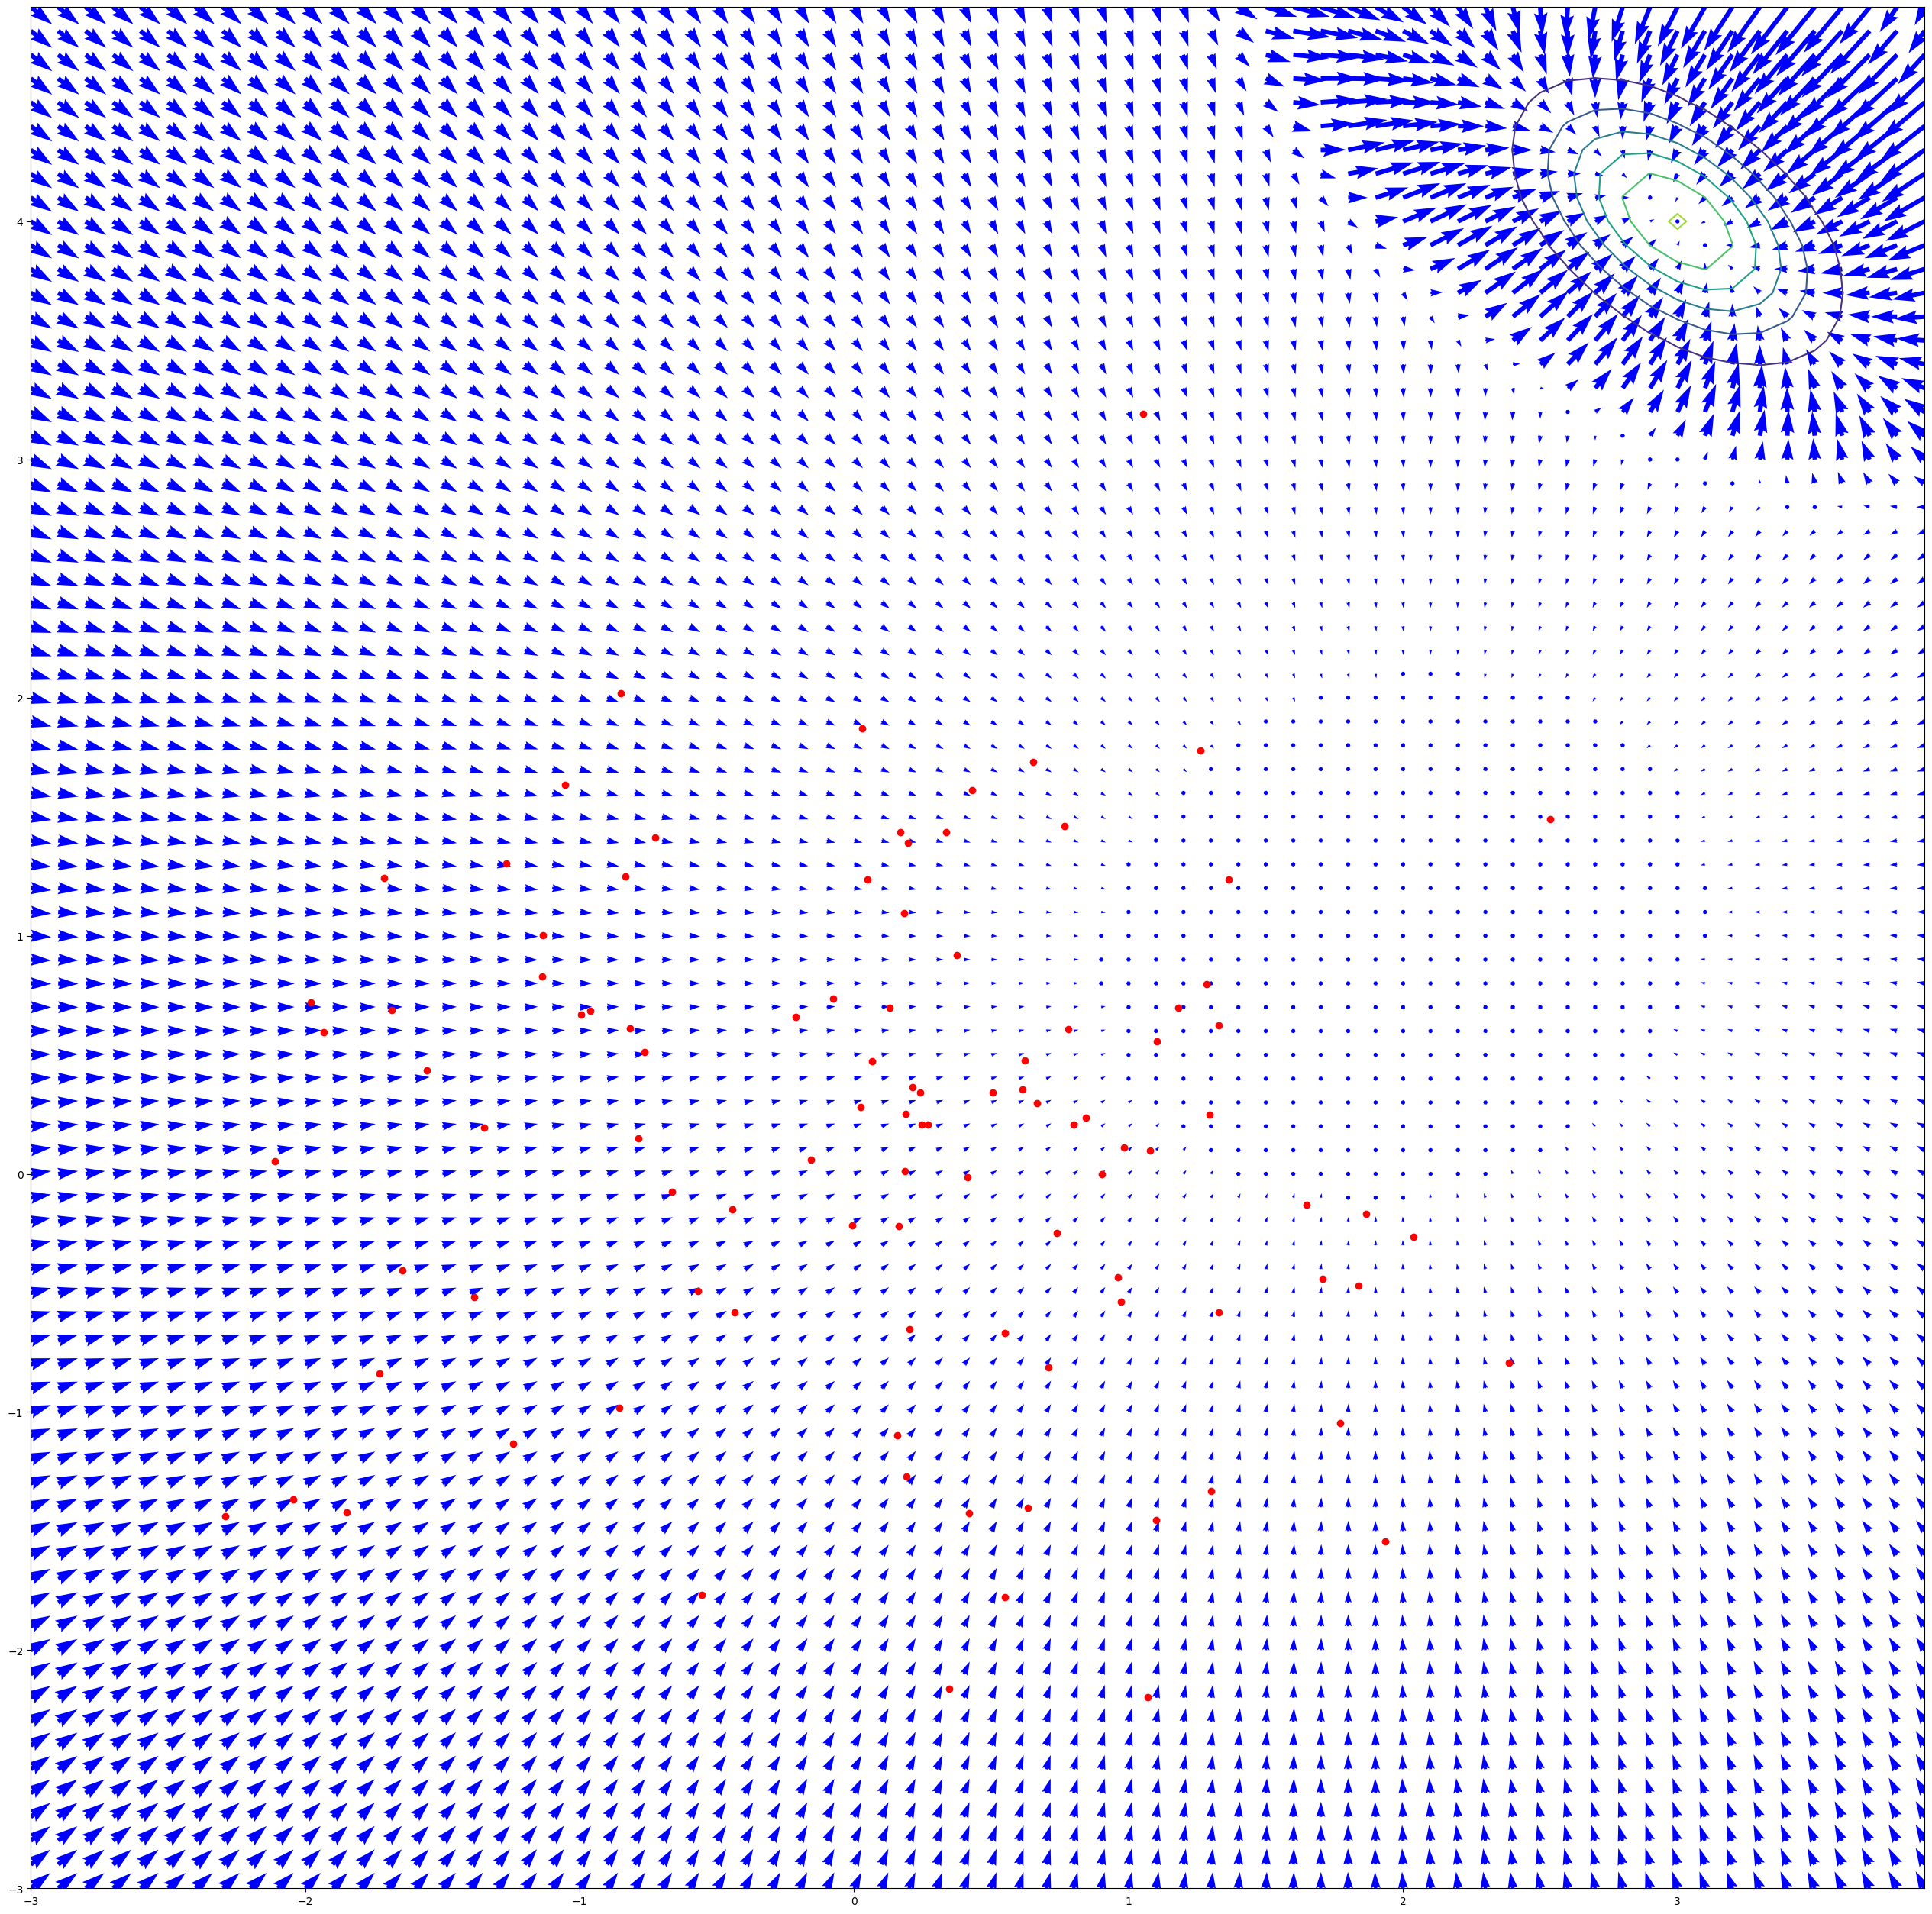

In [4]:
# Visualize the initial points
fig = plt.figure(figsize=(32, 32))
ax = fig.add_subplot()
X, Y = np.meshgrid(np.arange(-3, 4, 0.1), np.arange(-3, 5, 0.1))
# Construct score plot
scores = -jax.vmap(jax.grad(f))(np.stack([X.ravel(), Y.ravel()], axis=1))
dX = scores[:,0].reshape(X.shape)
dY = scores[:,1].reshape(Y.shape)
ax.quiver(X, Y, dX, dY, color='b')
pdfs = jax.vmap(target_pdf)(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)
# Construct density plot
ax.contour(X, Y, pdfs)

ax.scatter(x0s[:, 0], x0s[:,1], color="r")
plt.show()

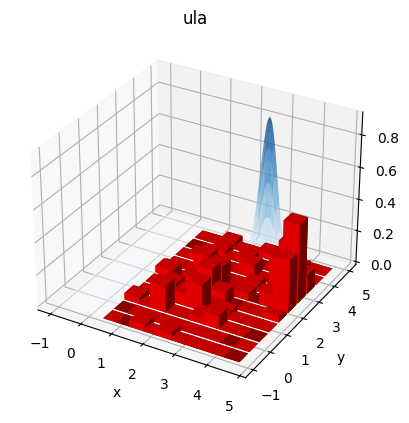

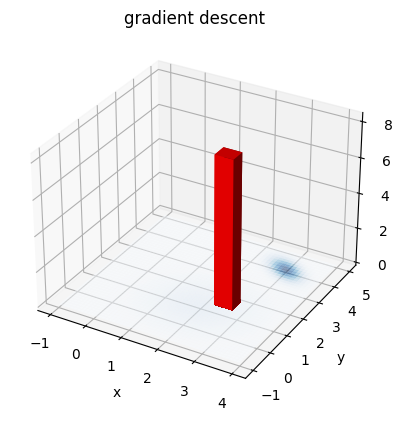

In [5]:
# visualize the xs

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(xs_ula[:,0], xs_ula[:,1], density=True)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color="red")
densities, X, Y = get_target_in_grid(target_pdf, [-1, 4], [-1, 5])
ax.plot_surface(X, Y, densities, cmap=cm.Blues, alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("ula")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(xs_gradient_descent[:,0], xs_gradient_descent[:,1], density=True)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color="red")
densities, X, Y = get_target_in_grid(target_pdf, [-1, 4], [-1, 5])
ax.plot_surface(X, Y, densities, cmap=cm.Blues, alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("gradient descent")

plt.show()

In [6]:
print(f"global optimal value:{min_f:2f}, obtained at:{argmin_f}")
print(f"ula min value:{ula_best_f:2f}, obtained at:{ula_best_xs}")
print(f"grad descent min value:{gradient_descent_best_f:2f}, obtained at:{gradient_descent_best_xs}")

global optimal value:0.084340, obtained at:[3. 4.]
ula min value:0.132273, obtained at:[3.0118375 3.9098084]
grad descent min value:2.305924, obtained at:[1.9999951 0.9999974]


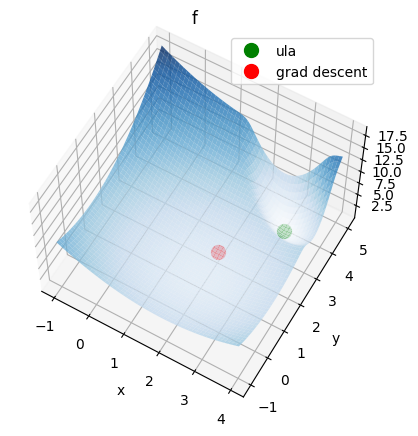

In [7]:
fs, X, Y = get_target_in_grid(f, [-1, 4], [-1, 5])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, fs, cmap=cm.Blues, alpha=0.8)
ax.plot(ula_best_xs[0], ula_best_xs[1], ula_best_f, "go", markersize=10, label="ula")
ax.plot(gradient_descent_best_xs[0], gradient_descent_best_xs[0], gradient_descent_best_f, "ro", markersize=10, label="grad descent")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("f")
ax.view_init(elev=60)
ax.legend()
plt.show()